In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import StatevectorSimulator, QasmSimulator, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import visualize_transition, plot_histogram, circuit_drawer, plot_bloch_multivector, plot_state_qsphere, array_to_latex
import Our_Qiskit_Functions as oq
from qiskit.circuit.library import QFT
from qiskit import quantum_info as qi
import numpy as np 
from numpy import pi
import math as m
import random
import matplotlib.pyplot as plt
import warnings
from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

warnings.filterwarnings('ignore')

S_simulator = StatevectorSimulator()
M_simulator = QasmSimulator()

In [32]:
#we will normailize weightage
distanceList = [10, 15, 20, 35, 25, 30] # a-b, a-c, a-d, b-c, b-d, c-d
sorted_weight = np.sort(distanceList)[::-1]
print("sorted_weight", sorted_weight)
normalised_weight = distanceList / (sum(sorted_weight[:4]))
print("{:.2f}".format(normalised_weight[0]), "{:.2f}".format(normalised_weight[1]), "{:.2f}".format(normalised_weight[2]), "{:.2f}".format(normalised_weight[3]), "{:.2f}".format(normalised_weight[4]), "{:.2f}".format(normalised_weight[5]))       

sorted_weight [35 30 25 20 15 10]
0.09 0.14 0.18 0.32 0.23 0.27


In [34]:
## solutions
# A->B->C->D->A
# A->B->D->C->A
# A->C->B->D->A

print("Solution1: {:.2f}".format(normalised_weight[0]+normalised_weight[3]+normalised_weight[5]))   
print("Solution2: {:.2f}".format(normalised_weight[0]+normalised_weight[4]+normalised_weight[5]))
print("Solution3: {:.2f}".format(normalised_weight[1]+normalised_weight[3]+normalised_weight[4]))



Solution1: 0.68
Solution2: 0.59
Solution3: 0.68


In [35]:
m=8 # number of qubits for eigengates

U111 =1
U112 = np.exp(2j*pi*normalised_weight[0])
U113 = np.exp(2j*pi*normalised_weight[1])
U114 = np.exp(2j*pi*normalised_weight[2])
U1=np.diag([U111, U112, U113, U114])
U221 =np.exp(2j*pi*normalised_weight[0])
U222 = 1
U223 = np.exp(2j*pi*normalised_weight[3])
U224 = np.exp(2j*pi*normalised_weight[4])
U2=np.diag([U221, U222, U223, U224])
U331 =np.exp(2j*pi*normalised_weight[1])
U332 = np.exp(2j*pi*normalised_weight[3])
U333 = 1
U334 = np.exp(2j*pi*normalised_weight[5])
U3=np.diag([U331, U332, U333, U334])
U441 =np.exp(2j*pi*normalised_weight[2])
U442 = np.exp(2j*pi*normalised_weight[4])
U443 = np.exp(2j*pi*normalised_weight[5])
U444 = 1
U4=np.diag([U441, U442, U443, U444])

U = np.kron(U1, np.kron(U2, np.kron(U3, U4)))

print(np.all(np.diag(U) != 0)) # confirming only the diagonal is being used.
Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()





True


In [45]:
## confirming the eigenstates are correct
eigstatelist = ['01101100', #1230 A->B->C->D->A
'01110010', #1302 A->B->D->C->A
'10110100'] #2310 A->C->B->D->A
print("Eigenstates: ", eigstatelist)
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check
#print(eiglistint)


Eigenstates:  ['01101100', '01110010', '10110100']


array([0.86363636, 0.72727273, 0.86363636])

In [37]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [39]:
def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = S_simulator.run(obj, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(np.asarray(statevec)),2)) 
  for i in np.arange( int(len(np.asarray(statevec))) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)

In [40]:
def Measurement(quantumcircuit, **kwargs):
  '''
  Executes a measurement(s) of a QuantumCircuit object for tidier printing
  Keyword Arguments:
  shots (integer) - number of trials to execute for the measurement(s)
  return_M (Bool) - indictaes whether to return the Dictionary object containng measurement resul
  print_M (Bool) - indictaes whether to print the measurement results
  column (Bool) - prints each state in a vertical column
  '''
  p_M = True
  S=1
  ret = False
  NL = False
  if 'shots' in kwargs:
    S = int(kwargs['shots'])
  if 'return_M' in kwargs:
    ret = kwargs['return_M']
  if 'print_M' in kwargs:
    p_M = kwargs['print_M']
  if 'column' in kwargs:
    NL = kwargs['column']
  M1 = M_simulator.run(quantumcircuit, shots=S).result().get_counts(quantumcircuit)
  M2 = {}
  k1 = list(M1.keys())
  v1 = list(M1.values())
  for k in np.arange(len(k1)):
    key_list = list(k1[k])
    new_key = ''
    for j in np.arange(len(key_list)):
      new_key = new_key+key_list[len(key_list)-(j+1)]
    M2[new_key] = v1[k]
  if(p_M):
    k2 = list(M2.keys())
    v2 = list(M2.values())
    measurements = ''
    for i in np.arange( len(k2) ):
      m_str = str(v2[i])+'|'
      for j in np.arange(len(k2[i])):
        if( k2[i][j] == '0' ):
          m_str = m_str+'0'
        if( k2[i][j] == '1' ):
          m_str = m_str+'1'
        if( k2[i][j] == ' ' ):
          m_str = m_str+'>|'
      m_str = m_str+'>   '
      if(NL):
        m_str = m_str + '\n'
      measurements = measurements + m_str
    print(measurements)
  if(ret):
    return M2

In [71]:
def bitstring_converter(string):

    '''
    converts binary values < 1 to decimal
    specifically for the results retrieved
    from simulation
    '''
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
        if i == len(string)-1:
            values.append(value)
    return values[::-1]

def SingleHamiltonianCycle(eig, n):
    m=8
    # we need a register for the eigenstate:
    eigst = QuantumRegister(m, name = 'eigenstate')
    # we need two registers for the constrained problem:
    phase = QuantumRegister(n, name = 'phase')
    #phase_c = QuantumRegister(n, name = 'phase c')
    cr = ClassicalRegister(n, 'output')
    #cr_c = ClassicalRegister(n, 'output c')
    # constructing the circuit (Initialization):
    qc = QuantumCircuit(phase,eigst, cr)
    # Apply H-Gates to phase qubits:
    for qubit in range(n):
        qc.h(qubit)
    for ind, val in enumerate(eig):
        if(int(val)):
            qc.x(ind + n)
    ## Phase Estimation
    eig_qubits = np.arange(0,m) + n
    repetitions = 1
    for counting_qubit in range(n):      
        applied_qubits = np.append([counting_qubit], [eig_qubits])
        for i in range(repetitions):
            qc.append(CUgate, list(applied_qubits)); # This is CU
        repetitions *= 2
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
    qc.barrier()
    qc.measure(phase,cr)
    return qc

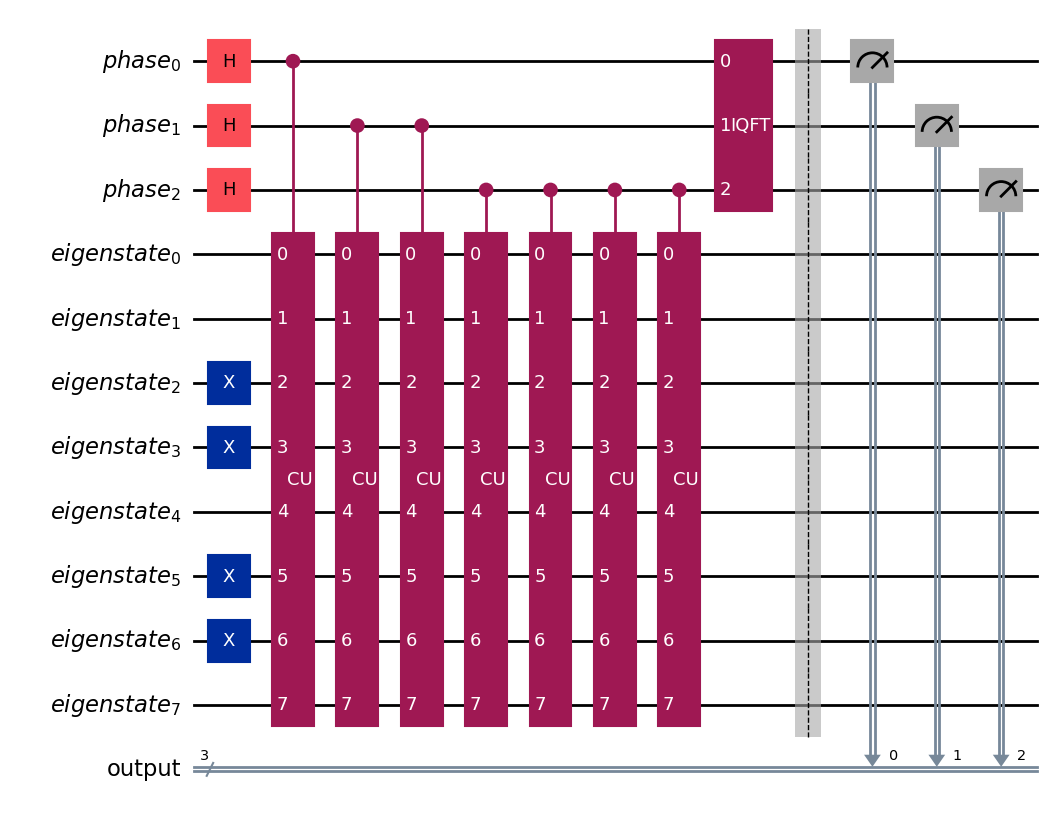

In [73]:
n = 3 ## number of estimation qubits.
## A->B->C->D->A
eig = eigstatelist[0]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc2 = SingleHamiltonianCycle(eig, n)
qc2.draw(fold=-1, output='mpl')

Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='c62c3691-b7c6-4454-9d2a-282553bdc75e', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x7': 1002, '0x6': 10, '0x0': 5, '0x2': 2, '0x5': 1, '0x1': 2, '0x4': 2}), header=QobjExperimentHeader(creg_sizes=[['output', 3]], global_phase=5.1742566503371705, memory_slots=3, n_qubits=11, name='circuit-317', qreg_sizes=[['phase', 3], ['eigenstate', 8]], metadata={}), status=DONE, seed_simulator=625969499, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 11, 'num_clbits': 3, 'time_taken': 0.0849312, 'sample_measure_time': 0.0009476, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], 'max_memory_mb': 8067, 'measure_sampling': Tru

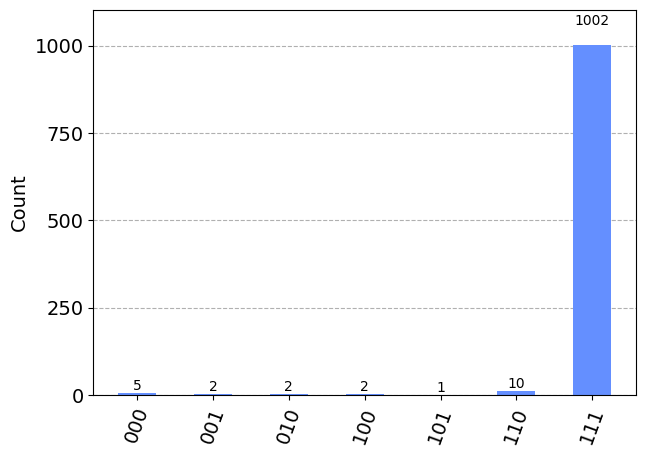

In [78]:
simulator = Aer.get_backend('qasm_simulator')
qc1 = transpile(qc1, simulator)
result = simulator.run(qc1).result()
counts1 = result.get_counts(qc1)
print(result)
plot_histogram(counts1)

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
provider = QiskitRuntimeService(channel="ibm_quantum", token="token")
provider = provider.get_backend("ibm_kyiv")
backend = provider
print("least busy backend: ", backend)

least busy backend:  <IBMBackend('ibm_kyiv')>


In [74]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
# from qiskit.tools.monitor import job_monitor

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
pm_circuit = pm.run(qc2)
sampler = Sampler(backend)
job = sampler.run([(pm_circuit)])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)
# sampler.options.default_shots = 1024  # Options can be set using auto-complete.
#job = sampler.run([pm_circuit],shots=1024)
#job = job.result()
# job_monitor(job, interval=2)
#print(job)

job id: czkv6fstj3e0008jssdg
PrimitiveResult([{'__type__': 'SamplerPubResult', '__value__': {'data': DataBin<>(output=BitArray(<shape=(), num_shots=4096, num_bits=3>)), 'metadata': {'circuit_metadata': {}}}}], metadata={'execution': {'execution_spans': {'__type__': 'ExecutionSpanCollection', '__value__': {'spans': [{'__type__': 'DoubleSliceSpan', '__value__': {'start': datetime.datetime(2025, 3, 29, 8, 45, 57, 583367), 'stop': datetime.datetime(2025, 3, 29, 8, 46, 24, 871637), 'data_slices': {'0': [[4096], 0, 1, 0, 4096]}}}]}}}, 'version': 2})


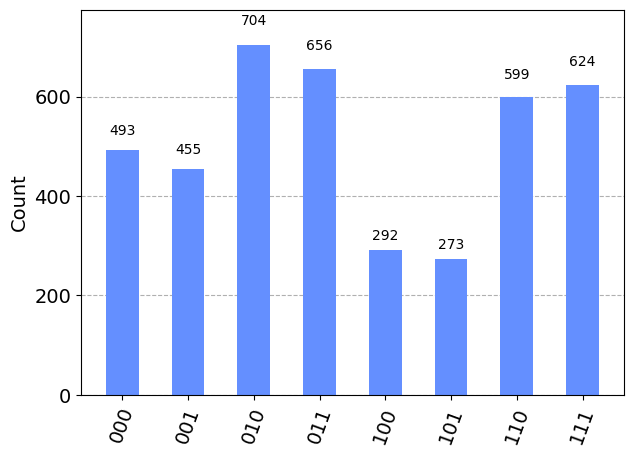

In [77]:
# use local simulator
answer = result[0]['__value__']['data'].output.get_counts()

plot_histogram(answer)